<a href="https://colab.research.google.com/github/21092004Goda/data_anal/blob/main/Lab_1_Computer_Vision_and_Pattern_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 1
**Сбор, визуализация и анализ данных по графу (cs.CV, arXiv)**

Кратко:
- Скачиваем метаданные arXiv.
- Извлекаем ключевые слова моделью Transformers.
- Строим граф ключевых слов и граф публикаций.
- Анализируем сообщества и центральные узлы.

*Внимание:* извлечение ключевых слов может быть долгим. Рекомендуется GPU и кеширование промежуточных результатов.


In [34]:
%%capture
!pip install feedparser

In [35]:
import feedparser
import urllib.request as libreq
import pandas as pd

## Сбор данных с arXiv

In [36]:
# data collection

with libreq.urlopen('http://export.arxiv.org/api/query?search_query=all:cs.CV&start=0&max_results=1000') as url:
  r = url.read()
print(r)

b'<?xml version="1.0" encoding="UTF-8"?>\n<feed xmlns="http://www.w3.org/2005/Atom">\n  <link href="http://arxiv.org/api/query?search_query%3Dall%3Acs.CV%26id_list%3D%26start%3D0%26max_results%3D1000" rel="self" type="application/atom+xml"/>\n  <title type="html">ArXiv Query: search_query=all:cs.CV&amp;id_list=&amp;start=0&amp;max_results=1000</title>\n  <id>http://arxiv.org/api/Us4TmgaiaHBxlhlMNGOB3sxrnVQ</id>\n  <updated>2025-09-22T00:00:00-04:00</updated>\n  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">167528</opensearch:totalResults>\n  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>\n  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">1000</opensearch:itemsPerPage>\n  <entry>\n    <id>http://arxiv.org/abs/0903.0134v2</id>\n    <updated>2010-01-08T10:32:52Z</updated>\n    <published>2009-03-01T11:10:27Z</published>\n    <title>Recognition of Regular Shapes in 

## Проверка уникальности заголовков

In [37]:
# unique titles

docs = feedparser.parse(r)
titles = [d["title"] for d in docs["entries"]]
len(set(titles))

1000

## Извлечение ключевых слов (Transformers)

Модель: `ilsilfverskiold/tech-keywords-extractor`.


In [38]:
%%time
# keywords extraction

from transformers import pipeline

pipe = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

Device set to use cuda:0


CPU times: user 1.09 s, sys: 173 ms, total: 1.26 s
Wall time: 2.11 s


In [39]:
%time
# data extraction example

doc = feedparser.parse(r)
title = doc['entries'][0]['title']
abstract = doc['entries'][0]['summary']
authors = [author['name'] for author in doc['entries'][0]['authors']]
tags = [tag['term'] for tag in doc['entries'][0]['tags']]

keywords = pipe(abstract)[0]["generated_text"].split(", ")


print(f"Title: {title}\n\nAuthors: {authors}\n\nAbstract: {abstract}\n\nTags: {tags}\n\nKeywords: {keywords}")

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 17.9 µs
Title: Recognition of Regular Shapes in Satelite Images

Authors: ['Ahmad Reza Eskandari', 'Ali Pourmohammad']

Abstract: This paper has been withdrawn by the author ali pourmohammad.

Tags: ['cs.CV']

Keywords: ['Paper', 'Ali Pourmohammad']


In [40]:
%time

pubs = []
for entry in docs["entries"]:
  data = {"title": entry['title'],
          "abstract": entry['summary'],
          "authors": [author['name'] for author in entry['authors']],
          "tags": [tag['term'] for tag in entry['tags']]}
  pubs.append(data)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


## Формирование DataFrame

In [41]:
df = pd.DataFrame(pubs)
df

,title,abstract,authors,tags
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"[Ahmad Reza Eskandari, Ali Pourmohammad]",[cs.CV]
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"[Arthur Szlam, Koray Kavukcuoglu, Yann LeCun]",[cs.CV]
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,[Anish Acharya],[cs.CV]
3,Exploration of object recognition from 3D poin...,We present our latest experiment results of ob...,[Lin Duan],[cs.CV]
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"[Sifeng He, Bahram Jalali]",[cs.CV]
...,...,...,...,...
995,A massively parallel multi-level approach to a...,We consider a variational method to solve the ...,"[Diane Gilliocq-Hirtz, Zakaria Belhachmi]",[cs.CV]
996,A Novel Approach For Finger Vein Verification ...,"In this paper, we propose a method for user Fi...","[Mohsen Fayyaz, Masoud PourReza, Mohammad Haji...",[cs.CV]
997,Low Rank Representation on Riemannian Manifold...,"In this paper, we present a novel low rank rep...","[Yifan Fu, Junbin Gao, Xia Hong, David Tien]",[cs.CV]
998,Preprint ARPPS Augmented Reality Pipeline Pros...,This is the preprint version of our paper on I...,"[Xiaolei Zhang, Yong Han, DongSheng Hao, Zhiha...",[cs.CV]


## Генерация ключевых слов для всех абстрактов

In [42]:
%%time
df["keywords"] = df["abstract"].apply(lambda x: pipe(x)[0]["generated_text"].split(", "))

CPU times: user 5min 32s, sys: 502 ms, total: 5min 32s
Wall time: 6min 32s


In [43]:
df["authors"] = df["authors"].apply(lambda x: ", ".join(x))
df["tags"] = df["tags"].apply(lambda x: ", ".join(x))
df["keywords"] = df["keywords"].apply(lambda x: ", ".join(x))

df

,title,abstract,authors,tags,keywords
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"Ahmad Reza Eskandari, Ali Pourmohammad",cs.CV,"Paper, Ali Pourmohammad"
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"Arthur Szlam, Koray Kavukcuoglu, Yann LeCun",cs.CV,"Matching Pursuit, K-SVD, Translation invariant"
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,Anish Acharya,cs.CV,"ObjectDetection, HOG, Feature Pyramid, Templat..."
3,Exploration of object recognition from 3D poin...,We present our latest experiment results of ob...,Lin Duan,cs.CV,"Object Recognition, 3D Point Cloud, Moving Car"
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"Sifeng He, Bahram Jalali",cs.CV,"Brain MRI, Algorithm, Resolution Enhancement"
...,...,...,...,...,...
995,A massively parallel multi-level approach to a...,We consider a variational method to solve the ...,"Diane Gilliocq-Hirtz, Zakaria Belhachmi",cs.CV,"Vilational Method, Optical Flow, MUMPS, Domain..."
996,A Novel Approach For Finger Vein Verification ...,"In this paper, we propose a method for user Fi...","Mohsen Fayyaz, Masoud PourReza, Mohammad Hajiz...",cs.CV,"Finger Vein Authentication, FVA, Gaussian Dist..."
997,Low Rank Representation on Riemannian Manifold...,"In this paper, we present a novel low rank rep...","Yifan Fu, Junbin Gao, Xia Hong, David Tien",cs.CV,"Low Rank Representation, LRR, Computer Vision,..."
998,Preprint ARPPS Augmented Reality Pipeline Pros...,This is the preprint version of our paper on I...,"Xiaolei Zhang, Yong Han, DongSheng Hao, Zhihan Lv",cs.CV,"ICONIP, ARGIS, Machine Vision, Sensor, Neural ..."


In [44]:
print("Кол-во публикаций:", len(df))
print("Средняя длина аннотации:", df["abstract"].apply(lambda x: len(x.split())).mean())
all_keywords = [kw for kws in df["keywords"].str.split(",") for kw in kws]
print("Уникальных ключевых слов:", len(set(all_keywords)))
pd.Series(all_keywords).value_counts().head(20)


Кол-во публикаций: 1000
Средняя длина аннотации: 69.327
Уникальных ключевых слов: 3209


,count
Computer Vision,52
Algorithms,33
Image Processing,21
CNN,19
Algorithm,15
Deep Learning,14
Pattern Recognition,14
Image Segmentation,13
Deep Learning,13
Machine Learning,13


## Сохранение результата

In [45]:
df.to_csv("multimedia_250.csv", index=False)

## Построение графа ключевых слов

Граф: узлы = ключевые слова, ребро между двумя словами если они встречаются в одной статье.

Вес ребра = количество совместных появлений.

Далее строим взвешенный граф и выполняем кластеризацию.


In [46]:
import pandas as pd
import networkx as nx
from itertools import combinations, chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import itemgetter
import plotly.graph_objects as go

In [47]:
df = pd.read_csv("multimedia_250.csv")
df.sample(5)

,title,abstract,authors,tags,keywords
132,Head Gesture Recognition using Optical Flow ba...,This paper describes a technique of real time ...,"Parimita Saikia, Karen Das",cs.CV,"Real Time Head Gesture Recognition, Gaussian M..."
437,A Short Note on Evaluating RepNet for Temporal...,We discuss some consistent issues on how RepNe...,"Debidatta Dwibedi, Yusuf Aytar, Jonathan Tomps...","cs.CV, cs.AI, cs.LG","RepNet, Performance Evaluation, Google, Google..."
591,Edge detection based on morphological amoebas,Detecting the edges of objects within images i...,"Won Yeol Lee, Young Woo Kim, Se Yun Kim, Jae Y...",cs.CV,"Neoeba, Image Processing, Image Detection, Man..."
55,A Modified Convolutional Network for Auto-enco...,This brief paper reports the shortcoming of a ...,Erico Tjoa,"cs.CV, cs.LG, eess.IV","Convolutional Neuralnetwork, Pattern Theory"
554,Cost-Effective Implementation of Order-Statist...,Vector operators based on robust order statist...,"M. Emre Celebi, Hassan A. Kingravi, Rastislav ...","cs.CV, I.4.3","Vector Filters, Robust Order Statistics, Multi..."


In [48]:
klist = [[word.strip() for word in keywords.split(",") if word]
         for keywords in df["keywords"].tolist()]
klist[:3]

[['Paper', 'Ali Pourmohammad'],
 ['Matching Pursuit', 'K-SVD', 'Translation invariant'],
 ['ObjectDetection', 'HOG', 'Feature Pyramid', 'Template Matching']]

In [49]:
edges = list(chain(*[list(combinations(words, 2)) for words in klist]))
edges = [tuple(sorted(edge)) for edge in edges]
weighted_edges = [(edge[0], edge[1], {"weight": edges.count(edge)}) for edge in set(edges)]
weighted_edges[:10]

[('DCT', 'Mixture of Gaussians', {'weight': 1}),
 ('Clarkson University', 'YFA', {'weight': 1}),
 ('Accuracy', 'Stereo Matching Algorithms', {'weight': 1}),
 ('EAR', 'MAR', {'weight': 1}),
 ('Feature Extraction', 'Skin Filtering', {'weight': 1}),
 ('FuzzyCMeans', 'Text Extraction', {'weight': 1}),
 ('Humeprimal-dual algorithm', 'Optimal-transport distances', {'weight': 1}),
 ('Bayes Ying Yang', 'SIGNATURE Verification', {'weight': 1}),
 ('Aesthetic Gradients', 'Quantitative Experiments', {'weight': 1}),
 ('Algorithms', 'organization', {'weight': 1})]

In [50]:
len(set(edges)), len(weighted_edges)

(6543, 6543)

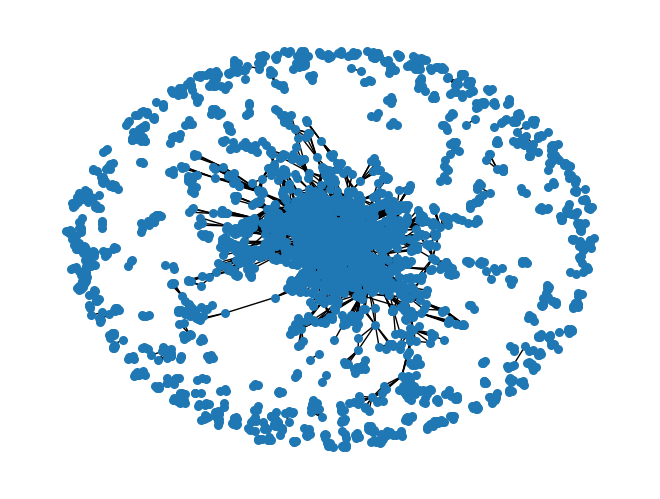

In [51]:
G = nx.Graph()
G.add_edges_from(weighted_edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

## Кластеризация (Louvain) и визуализация

- Находим сообщества Louvain.
- Выводим число кластеров и модульность.
- Визуализируем топ-3 сообщества статично (matplotlib) и интерактивно (Plotly).


In [52]:
communities = nx.community.louvain_communities(G, resolution=0.9)
print(f"# of clusters: {len(communities)}, Modularity: {nx.community.modularity(G, communities)}")

# of clusters: 341, Modularity: 0.8885584595562667


In [53]:
comm_data = [{"n_of_nodes": len(comm), "nodes": comm} for comm in communities]
cdf = pd.DataFrame(comm_data)
cdf.describe()

,n_of_nodes
count,341.000000
mean,9.046921
std,20.434922
min,2.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,178.000000


In [54]:
top3_comm = cdf.nlargest(3, "n_of_nodes")
top3_comm

,n_of_nodes,nodes
11,178,"{Object Identification, Makkah, ISIC Challenge..."
12,126,"{SVM, CLIP, Patterned Textures, Histogram of O..."
125,126,"{Laplacian Eigenbases, Low Rank Representation..."


In [55]:
nodes = list(chain(*top3_comm["nodes"].tolist()))
S = G.subgraph(nodes)

In [56]:
for i, nodes in enumerate(top3_comm["nodes"], start=1):
    sub_keywords = [kw for kw in nodes]
    print(f"\nКластер {i}, размер: {len(nodes)}")
    print(pd.Series(sub_keywords).value_counts().head(10))



Кластер 1, размер: 178
Object Identification             1
Makkah                            1
ISIC Challenge                    1
Video Data                        1
Yale B                            1
Analysis of Space-Time Objects    1
Cognitive Science                 1
Action Recognition                1
Bag of Words                      1
Pytorch                           1
Name: count, dtype: int64

Кластер 2, размер: 126
SVM                                      1
CLIP                                     1
Patterned Textures                       1
Histogram of Oriented Gradients (HOG)    1
Ladars                                   1
Convolutional Neural Networks            1
HR Grid                                  1
Species Analysis                         1
Storage Devices                          1
CNNs                                     1
Name: count, dtype: int64

Кластер 3, размер: 126
Laplacian Eigenbases                1
Low Rank Representation             1
Cheirality

In [57]:
def create_community_node_colors(graph, communities):
    colors = list(set(mcolors.TABLEAU_COLORS.values()))
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

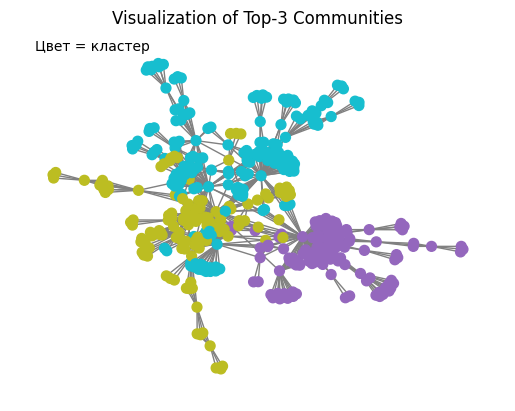

In [58]:
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    title = f"Visualization of Top-3 Communities"
    pos = nx.spring_layout(graph, iterations=100, seed=23)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=50,
        node_color=node_colors,
        edge_color="gray",
        with_labels=False
    )
    plt.text(0.05, 0.95, "Цвет = кластер", transform=plt.gca().transAxes)


visualize_communities(S, top3_comm["nodes"].tolist(), 1)

In [59]:
communities = top3_comm["nodes"].tolist()
pos = nx.spring_layout(S, iterations=100, seed=23)

# edges coordinates
x_nodes, y_nodes = zip(*pos.values())
edge_x, edge_y = [], []
for edge in S.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# degree labels
node_labels = [f"Node {n}<br>Degree: {S.degree(n)}" for n in S.nodes()]
node_degrees = [S.degree(n) for n in S.nodes()]
node_colors_list = create_community_node_colors(S, communities)

fig = go.Figure()
# add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="gray"),
))

# add nodes
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes, mode="markers",
    marker=dict(size=[deg*1.1+5 for deg in node_degrees], color=node_colors_list),
    hoverinfo="text",
    text=node_labels
))

# background settings
fig.update_layout(
    title=f"Interactive Visualization of Top-3 Communities",
    showlegend=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

fig.show()

## Оценка центральностей

Вычисляем: degree, betweenness, closeness, eigenvector.
Выводим топ-5 узлов по каждой метрике. Интерпретация:
- degree → локальная важность,
- betweenness → «мосты» между кластерами,
- eigenvector → влияние через влиятельных соседей.


In [60]:
# top-10 nodes by degree centrality
[(node[0], round(node[1],2))
for node in sorted(nx.degree_centrality(S).items(), key=itemgetter(1), reverse=True)][:10]

[('Computer Vision', 0.22),
 ('Deep Learning', 0.14),
 ('Convolutional Neural Networks', 0.13),
 ('CNN', 0.11),
 ('Face Recognition', 0.07),
 ('SVM', 0.07),
 ('Convolutional Neural Network', 0.05),
 ('Semantic Segmentation', 0.05),
 ('CNNs', 0.04),
 ('Clustering', 0.04)]

In [61]:
# top nodes by degree centrality in top-3 communities

for i, nodes in enumerate(top3_comm["nodes"].tolist(), start=1):
  s = G.subgraph(nodes)
  top_node = max(nx.degree_centrality(s).items(), key=itemgetter(1))

  top3_nodes = [(node[0], round(node[1],2))
  for node in sorted(nx.degree_centrality(s).items(), key=itemgetter(1), reverse=True)][:3]

  print(f"# of cluster: {i}, Central node by degree: {(top_node[0], round(top_node[1], 2))}")
  print(f"Top-3 nodes: {top3_nodes}\n")


# of cluster: 1, Central node by degree: ('Deep Learning', 0.33)
Top-3 nodes: [('Deep Learning', 0.33), ('CNN', 0.2), ('Convolutional Neural Network', 0.13)]

# of cluster: 2, Central node by degree: ('Convolutional Neural Networks', 0.34)
Top-3 nodes: [('Convolutional Neural Networks', 0.34), ('SVM', 0.22), ('CNNs', 0.13)]

# of cluster: 3, Central node by degree: ('Computer Vision', 0.65)
Top-3 nodes: [('Computer Vision', 0.65), ('Semantic Segmentation', 0.17), ('Clustering', 0.14)]



In [62]:
metrics = {
    "degree": nx.degree_centrality(S),
    "betweenness": nx.betweenness_centrality(S),
    "closeness": nx.closeness_centrality(S),
    "eigenvector": nx.eigenvector_centrality(S)
}

for name, values in metrics.items():
    top5 = sorted(values.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop-5 {name} centrality:")
    for node, val in top5:
        print(f"{node}: {val:.3f}")



Top-5 degree centrality:
Computer Vision: 0.224
Deep Learning: 0.142
Convolutional Neural Networks: 0.128
CNN: 0.107
Face Recognition: 0.072

Top-5 betweenness centrality:
Computer Vision: 0.488
Convolutional Neural Networks: 0.325
Deep Learning: 0.290
CNN: 0.288
Convolutional Neural Network: 0.103

Top-5 closeness centrality:
Computer Vision: 0.462
CNN: 0.455
Convolutional Neural Networks: 0.447
Deep Learning: 0.436
Face Recognition: 0.379

Top-5 eigenvector centrality:
Computer Vision: 0.476
Convolutional Neural Networks: 0.298
Deep Learning: 0.268
CNN: 0.242
SVM: 0.155


## Граф публикаций и поиск похожих статей

Узлы = статьи. Ребро между статьями если у них есть общие ключевые слова.
Вес = число общих ключевых слов.

Реализована функция `find_similar_papers(paper_title, graph, top_n=5)` для поиска похожих работ.


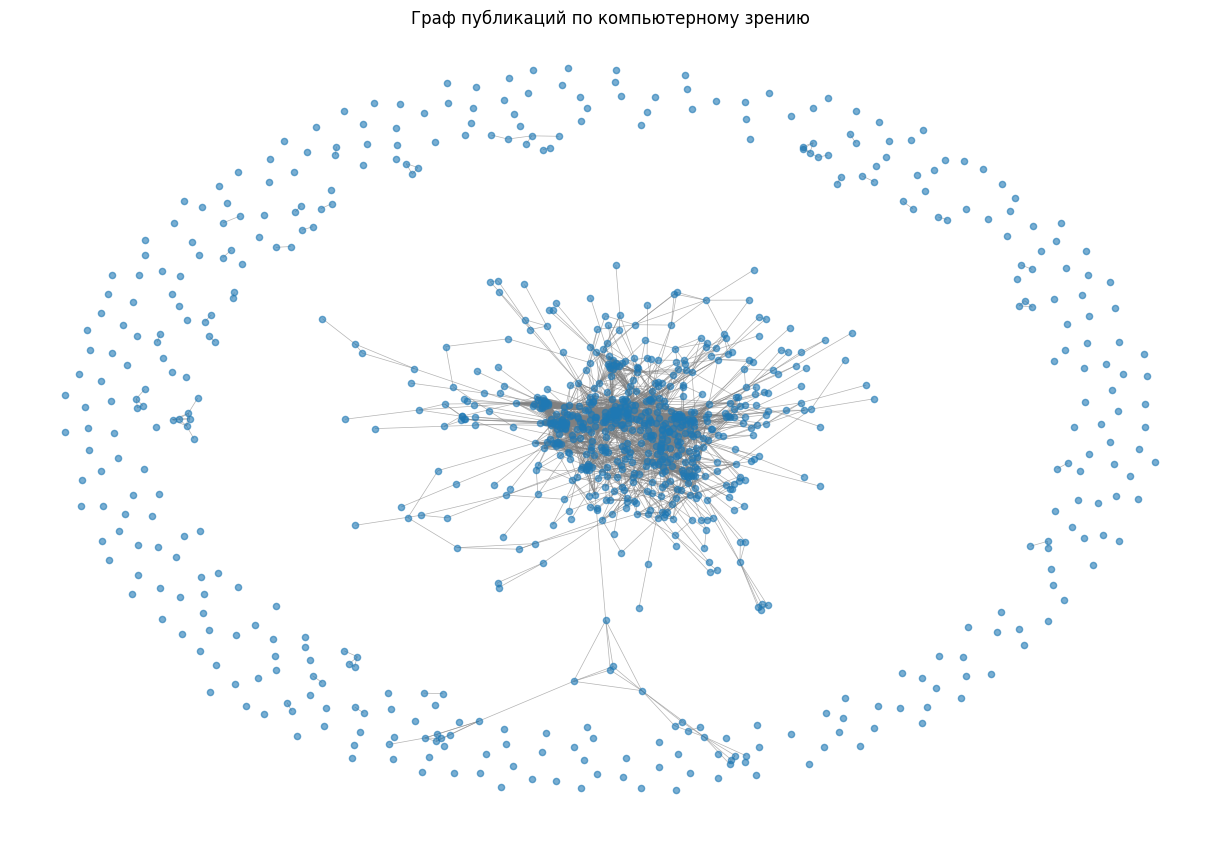

In [63]:
G_papers = nx.Graph()

for i, row in df.iterrows():
    G_papers.add_node(row['title'], abstract=row['abstract'], authors=row['authors'])

for i, row1 in df.iterrows():
    keywords1 = set(kw.strip() for kw in row1['keywords'].split(','))
    for j, row2 in df.iterrows():
        if i < j:
            keywords2 = set(kw.strip() for kw in row2['keywords'].split(','))
            common_keywords = keywords1.intersection(keywords2)
            weight = len(common_keywords)
            if weight > 0:
                G_papers.add_edge(row1['title'], row2['title'], weight=weight)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_papers, k=0.5, iterations=50)
nx.draw(G_papers, pos, node_size=20, alpha=0.6, edge_color='gray', width=0.5)
plt.title("Граф публикаций по компьютерному зрению")
plt.show()

In [64]:
def find_similar_papers(paper_title, graph, top_n=5):
    if paper_title not in graph:
        return "Статья не найдена в графе."

    # Собираем всех соседей и вес связи с ними
    neighbors = []
    for neighbor in graph.neighbors(paper_title):
        weight = graph[paper_title][neighbor]['weight']
        neighbors.append((neighbor, weight))

    # Сортируем по убыванию веса связи
    neighbors_sorted = sorted(neighbors, key=lambda x: x[1], reverse=True)
    return neighbors_sorted[:top_n]

# Пример использования
input_paper = df.iloc[3]['title']
similar = find_similar_papers(input_paper, G_papers)
for paper, weight in similar:
    print(f"Статья: {paper} | Общих ключевых слов: {weight}")

Статья: Logical methods of object recognition on satellite images using spatial
  constraints | Общих ключевых слов: 1
Статья: Visual Vocabulary Learning and Its Application to 3D and Mobile Visual
  Search | Общих ключевых слов: 1
Статья: Synthesising Dynamic Textures using Convolutional Neural Networks | Общих ключевых слов: 1
Статья: The Effect of Top-Down Attention in Occluded Object Recognition | Общих ключевых слов: 1
Статья: The use of Octree in point cloud analysis with application to cultural
  heritage | Общих ключевых слов: 1


In [65]:
print(f"Количество статей (узлов): {G_papers.number_of_nodes()}")
print(f"Количество связей (ребер): {G_papers.number_of_edges()}")
print(f"Плотность графа: {nx.density(G_papers):.3f}")
print(f"Средняя степень связности: {sum(dict(G_papers.degree()).values()) / G_papers.number_of_nodes():.1f}")

Количество статей (узлов): 1000
Количество связей (ребер): 5489
Плотность графа: 0.011
Средняя степень связности: 11.0


## Метрики графа и качества кластеризации

Реализованы:
- Coverage разбиения,
- Conductance для сообщества,
- Средняя conductance,
- Silhouette на спектральных эмбеддингах.

Эти метрики помогут оценить качество найденных сообществ.


In [66]:
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import silhouette_score
import numpy as np

# --- Метрики графа и кластеризации ---
def coverage_of_partition(G, communities):
    m = G.number_of_edges()
    if m == 0:
        return 0.0
    intra = 0
    for comm in communities:
        intra += G.subgraph(comm).number_of_edges()
    return intra / m

def conductance_of_community(G, community):
    comm = set(community)
    cut_edges = sum(
        G[u][v].get("weight", 1.0)
        for u in comm for v in G.neighbors(u)
        if v not in comm
    )
    vol_comm = sum(G.degree(u, weight="weight") for u in comm)
    vol_rest = sum(G.degree(u, weight="weight") for u in G if u not in comm)
    denom = min(vol_comm, vol_rest)
    return cut_edges / denom if denom > 0 else 0.0

def average_conductance(G, communities):
    return np.mean([conductance_of_community(G, c) for c in communities])

def silhouette_on_embeddings(G, communities, n_components=16):
    nodes = list(G.nodes())
    A = nx.to_scipy_sparse_array(G, nodelist=nodes, weight="weight", format='csr')
    A.indices = A.indices.astype(np.int32)
    A.indptr = A.indptr.astype(np.int32)
    embed = SpectralEmbedding(n_components=n_components, affinity='precomputed').fit_transform(A)
    label_map = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            label_map[n] = cid
    labels = np.array([label_map.get(n, -1) for n in nodes])
    mask = labels >= 0
    if len(set(labels[mask])) < 2:
        return float("nan")
    return silhouette_score(embed[mask], labels[mask])


# communities_all = полный список сообществ по всему графу ключевых слов
communities_all = nx.community.louvain_communities(G, resolution=0.9)

print("=== Метрики для графа ключевых слов ===")
print("Модульность:", nx.community.modularity(G, communities_all))
print("Coverage:", coverage_of_partition(G, communities_all))
print("Средняя conductance:", average_conductance(G, communities_all))
print("Silhouette (по спектральным эмбеддингам):", silhouette_on_embeddings(G, communities_all))
print()
print("=== Общие метрики графа ===")
print("Число узлов:", G.number_of_nodes())
print("Число рёбер:", G.number_of_edges())
print("Плотность графа:", nx.density(G))
print("Средний clustering coefficient:", nx.average_clustering(G))
if nx.is_connected(G):
    print("Средняя длина пути:", nx.average_shortest_path_length(G))
else:
    print("Средняя длина пути: граф несвязный")



=== Метрики для графа ключевых слов ===
Модульность: 0.8887559039271096
Coverage: 0.9157878648937796
Средняя conductance: 0.008172248894385158


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Silhouette (по спектральным эмбеддингам): 0.3423463262398279

=== Общие метрики графа ===
Число узлов: 3085
Число рёбер: 6543
Плотность графа: 0.001375426470495494
Средний clustering coefficient: 0.9073333147598779
Средняя длина пути: граф несвязный
